# Предсказание стоимости автомобиля по его VIN-номеру

## Описание

## Импорты

In [43]:
import pandas as pd
import numpy as np
import re
import time
import skimpy

import matplotlib.pyplot as plt
plt.style.use(('dark_background'))

import chime
chime.theme('mario')

In [ ]:
%load_ext chime

## Загрузка и обзор данных

In [6]:
pattern = r"\[(\w{17}):(\d+)\]"

with open("vin_ford_train.txt", "r") as file:
    data = file.readline()
    matches = re.findall(pattern, data)
    
    for match in matches[:5]:
        print(match)

('2FMDK3JC4BBA41556', '12500')
('3FA6P0H75ER208976', '14500')
('3FAHP08Z17R268380', '1300')
('1FMCU0GX3DUC59421', '15200')
('1FAHP2E89DG119368', '11600')


In [8]:
df = pd.DataFrame(matches, columns=["VIN", "Price"])
df.head()

,VIN,Price
0,2FMDK3JC4BBA41556,12500
1,3FA6P0H75ER208976,14500
2,3FAHP08Z17R268380,1300
3,1FMCU0GX3DUC59421,15200
4,1FAHP2E89DG119368,11600


In [182]:
def extract_vin_info(vin):
    """Извлекает информацию из VIN-кода:

manufacturer         Производитель
security_codes       Ремни безопаности / тормоза
model                Модель
engine               Двигатель
check_digit          Контрольный знак
model_year           Год
plant_code           Завод
serial_number        Серийный номер"""
    
    pattern = r"(\w{3})(\w)(\w{3})(\w)(\w)(\w)(\w)(\w{6})"
    match = re.match(pattern, vin)
    if match:
        manufacturer = match.group(1)
        security_codes = match.group(2)
        model = match.group(3)
        engine = match.group(4)
        check_digit = match.group(5)
        model_year = match.group(6)
        plant_code = match.group(7)
        serial_number = match.group(8)
        return pd.Series(
            {
                "manufacturer": manufacturer,
                "security_codes": security_codes,
                "model": model,
                "engine": engine,
                "check_digit": check_digit,
                "model_year": model_year,
                "plant_code": plant_code,
                "serial_number": serial_number,
            }
        )
    else:
        return pd.Series(
            {
                "manufacturer": None,
                "security_codes": None,
                "model": None,
                "engine": None,
                "check_digit": None,
                "model_year": None,
                "plant_code": None,
                "serial_number": None,
            }
        )

vin_example = df["VIN"][0]

print('Информация о VIN-коде:')
extract_vin_info(vin_example)

Информация о VIN-коде:


manufacturer         2FM
security_codes         D
model                K3J
engine                 C
check_digit            4
model_year             B
plant_code             B
serial_number     A41556
dtype: object

In [24]:
%%time
%%chime

df[
    [
        "manufacturer",
        "security_codes",
        "model",
        "engine",
        "check_digit",
        "model_year",
        "plant_code",
        "serial_number",
    ]
] = df["VIN"].apply(extract_vin_info)

df.head()

,VIN,Price,manufacturer,security_codes,model,engine,check_digit,model_year,plant_code,serial_number
0,2FMDK3JC4BBA41556,12500,2FM,D,K3J,C,4,B,B,A41556
1,3FA6P0H75ER208976,14500,3FA,6,P0H,7,5,E,R,208976
2,3FAHP08Z17R268380,1300,3FA,H,P08,Z,1,7,R,268380
3,1FMCU0GX3DUC59421,15200,1FM,C,U0G,X,3,D,U,C59421
4,1FAHP2E89DG119368,11600,1FA,H,P2E,8,9,D,G,119368


## EDA (разведочный анализ)

In [28]:
skimpy.skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 71884  │ │ string      │ 10    │                                                          │
│ │ Number of columns │ 10     │ └─────────────┴───────┘                                                          │
│ └───────────────────┴────────┘                                                                                  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                   ┃ NA     ┃ NA %       ┃ words per row               ┃ total words            ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ VIN                           │      0 │          0 │                           1 │                  71884 │  │
│ │ Price                         │      0 │          0 │                           1 │                  71884 │  │
│ │ manufacturer                  │      0 │          0 │                           1 │                  71884 │  │
│ │ security_codes                │      0 │          0 │                           1 │                  71884 │  │
│ │ model                         │      0 │          0 │                           1 │                  71884 │  │
│ │ engine                        │      0 │          0 │                           1 │                  71884 │  │
│ │ check_digit                   │      0 │          0 │                           1 │                  71884 │  │
│ │ model_year                    │      0 │          0 │                           1 │                  71884 │  │
│ │ plant_code                    │      0 │          0 │                           1 │                  71884 │  │
│ │ serial_number                 │      0 │          0 │                           1 │                  71884 │  │
│ └───────────────────────────────┴────────┴────────────┴─────────────────────────────┴────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71884 entries, 0 to 71883
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   VIN             71884 non-null  object
 1   Price           71884 non-null  object
 2   manufacturer    71884 non-null  object
 3   security_codes  71884 non-null  object
 4   model           71884 non-null  object
 5   engine          71884 non-null  object
 6   check_digit     71884 non-null  object
 7   model_year      71884 non-null  object
 8   plant_code      71884 non-null  object
 9   serial_number   71884 non-null  object
dtypes: object(10)
memory usage: 5.5+ MB


In [30]:
df.describe()

,VIN,Price,manufacturer,security_codes,model,engine,check_digit,model_year,plant_code,serial_number
count,71884,71884,71884,71884,71884,71884,71884,71884,71884,71884
unique,71884,643,14,26,365,32,11,25,21,68215
top,2FMDK3JC4BBA41556,11000,1FM,D,P0H,2,1,D,R,B55197
freq,1,574,18347,12370,6171,7015,6622,17286,10535,4


In [132]:
(df[['Price']].astype('float')).describe()

,Price
count,71884.000000
mean,14321.449377
std,7827.057238
min,1000.000000
25%,8800.000000
50%,13500.000000
75%,19500.000000
max,36500.000000


In [37]:
df['Price'] = df['Price'].astype('uint')

In [41]:
df.drop(columns='VIN').duplicated().sum()

0

- Пропусков не обнаружено.

- Price представляет собой целочисленные значения в диопозоне от 1000 дл 36500

- Есть дубликаты в serial_number, но полные дубликаты отсуствуют. 

### Price

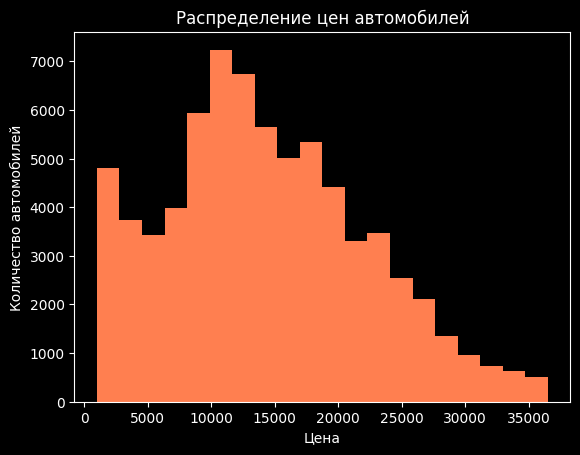

In [67]:
plt.hist(df['Price'], bins=20,color='coral')
plt.xlabel('Цена')
plt.ylabel('Количество автомобилей')
plt.title('Распределение цен автомобилей')
plt.show()

Судя по гистограмме, распределение цен имеет вид, близкий к нормальному, но с некоторым смещением вправо. Большинство автомобилей имеют цену в диапазоне от 5000 до 15000, но есть и более дорогие варианты.

### Соотношение моделей и производителей

In [76]:
display(df[['manufacturer']].value_counts())
print()
df[['model']].value_counts()

manufacturer
1FM             18347
1FT             17177
1FA             12844
3FA             12404
2FM              5829
1ZV              3257
1FB              1124
4F2               263
1FD               242
2FA               199
2FT               145
4N2                22
4F4                16
3FT                15
Name: count, dtype: int64

model
P0H      6171
P3F      3931
W1E      3897
P3K      1958
P0J      1487
         ... 
X27         1
U07         1
X15         1
P30         1
P66         1
Name: count, Length: 365, dtype: int64

In [73]:
df[['model']].value_counts().head(15)

model
P0H      6171
P3F      3931
W1E      3897
P3K      1958
P0J      1487
U0G      1465
K8D      1253
K3J      1190
P8E      1173
U9G      1141
W1C      1119
X1E      1026
W14       997
E2E       996
P2E       994
Name: count, dtype: int64

In [77]:
df[['model']].value_counts().tail(15)

model
P54      1
P51      1
Y0C      1
U14      1
K30      1
U8F      1
F46      1
T89      1
X2C      1
F25      1
X27      1
U07      1
X15      1
P30      1
P66      1
Name: count, dtype: int64

In [82]:
round(df.shape[0]/1000)

72

In [99]:
percentage = round(df.shape[0]/1000)

print(f'0.1% данных: {percentage}')
print(f'Модели которые встречаються реже: {(df.model.value_counts() < percentage).sum()}')
print('----------------------------------')
print(f'0.1% данных: {round(percentage/10)}')
print(f'Модели которые встречаються реже: {(df.model.value_counts() < percentage/10).sum()}')
print('----------------------------------')
print(f'Модели которые встречаються 1 раз: {(df.model.value_counts() == 1).sum()}')

0.1% данных: 72
Модели которые встречаються реже: 207
----------------------------------
0.1% данных: 7
Модели которые встречаються реже: 78
----------------------------------
Модели которые встречаються 1 раз: 19


Судя по результатам, в данных представлено 15 разных производителей и 365 разных моделей.

* **Производители**: Наиболее представленными производителями являются `1FM`, `1FT` и `1FA`. Остальные производители представлены в значительно меньшем количестве.
* **Модели**: Среди моделей наблюдается большее разнообразие. Модель `P0H` является самой распространенной, но есть много моделей, которые представленые в небольшом количестве.

### Зависимость цены от признаков

#### Год

In [106]:
df[['model_year']].value_counts()

model_year
D             17286
E             14990
C             12254
B              5860
8              3277
A              3262
7              2652
6              2555
5              2105
9              1736
4              1559
3              1274
2               951
F               653
1               601
Y               415
X               194
W               113
V                88
T                30
S                20
R                 6
H                 1
K                 1
P                 1
Name: count, dtype: int64

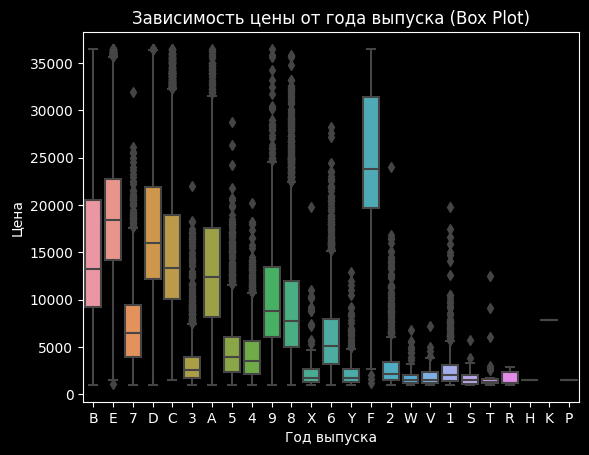

In [105]:
sns.boxplot(x='model_year',y='Price', data=df)
plt.xlabel('Год выпуска')
plt.ylabel('Цена')
plt.title('Зависимость цены от года выпуска (Box Plot)')
plt.show()

Можно сделать следующие наблюдения:

* Больше всего автомобилей распределены по годам D, E, C, B.
* Есть годы в которых всего 1 автомобиль (H,K,P)
* Год F обладает самыми дорогими автомобилями
* Цены на автомобили варьируются в зависимости от года выпуска.
* Наблюдается значительный разброс цен внутри каждого года выпуска. Это может быть связано с разными моделями, комплектациями и состоянием автомобилей.


#### Производитель

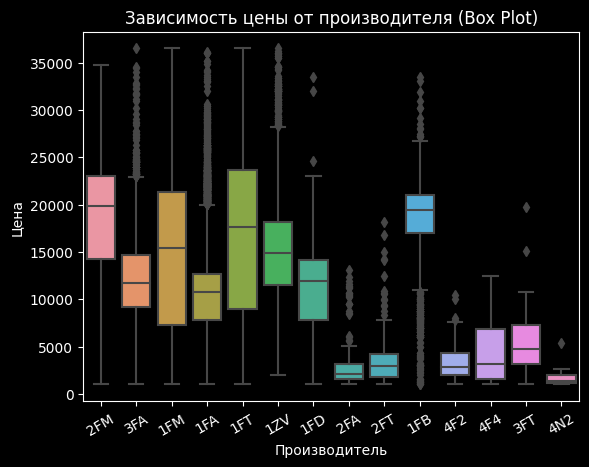

In [109]:
sns.boxplot(x='manufacturer',y='Price', data=df)
plt.xlabel('Производитель')
plt.ylabel('Цена')
plt.title('Зависимость цены от производителя (Box Plot)')
plt.xticks(rotation=30)
plt.show()

* Цены на автомобили варьируются в зависимости от производителя.
* Производители `2FM` и `1FB` имеют в среднем более высокие цены, чем остальные.
* Наблюдается значительный разброс цен внутри каждого производителя. Это может быть связано с разными моделями, комплектациями и состоянием автомобилей.

#### Модель

In [116]:
model_groups = (round(df.groupby('model')['Price'].agg(['mean', 'median', 'std', 'count']))
                .sort_values(by='count', ascending=False))
model_groups.head(30)

,mean,median,std,count
model,,,,
P0H,12764.0,13300.0,3138.0,6171
P3F,10166.0,10400.0,2460.0,3931
W1E,25589.0,25900.0,5647.0,3897
P3K,11125.0,11300.0,2281.0,1958
P0J,11506.0,11600.0,2265.0,1487
U0G,15562.0,16000.0,2516.0,1465
K8D,24344.0,24500.0,3958.0,1253
K3J,19953.0,20600.0,3504.0,1190
P8E,14968.0,14100.0,3481.0,1173


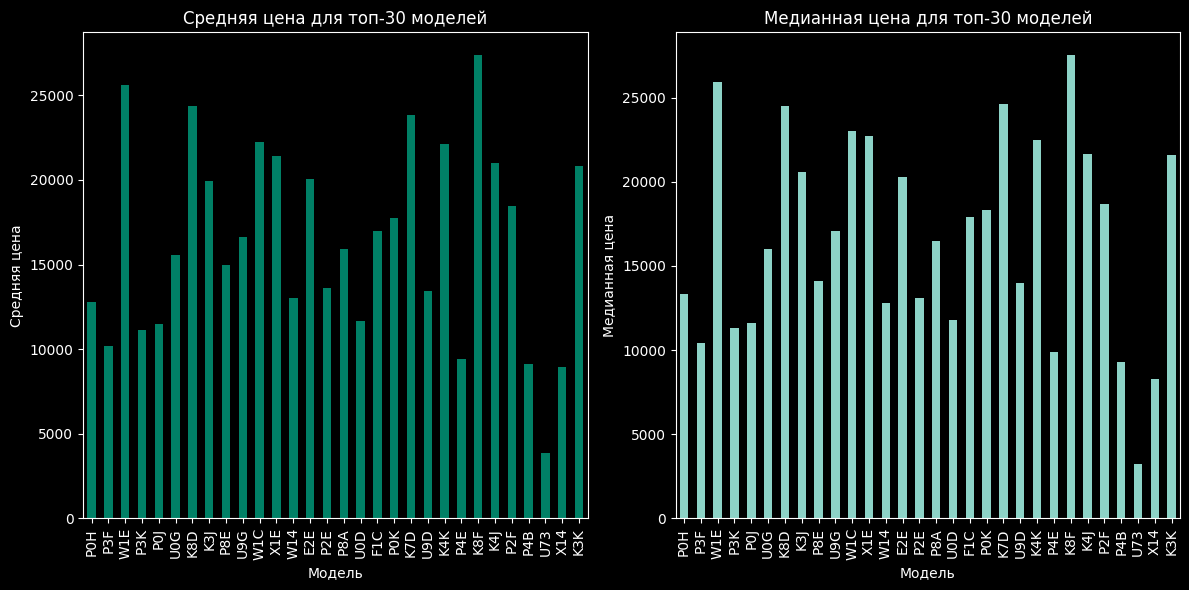

In [131]:
top_30_models = model_groups.head(30)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
top_30_models['mean'].plot(kind='bar',colormap='summer')
plt.xlabel('Модель')
plt.ylabel('Средняя цена')
plt.title('Средняя цена для топ-30 моделей')

plt.subplot(1, 2, 2)
top_30_models['median'].plot(kind='bar')
plt.xlabel('Модель')
plt.ylabel('Медианная цена')
plt.title('Медианная цена для топ-30 моделей')

plt.tight_layout() 
plt.show()

* **Распределение цен:** Как средние, так и медианные цены варьируются в зависимости от модели. Это указывает на то, что модель автомобиля является важным фактором, влияющим на его цену.
* **Сходство между средней и медианной:** В большинстве случаев средняя цена и медианная цена для каждой модели довольно близки. Это говорит о том, что распределение цен внутри каждой модели относительно симметрично и не имеет сильных выбросов.


#### Двигатель

In [153]:
df[['engine']].value_counts()

engine
2         7015
8         6101
C         4806
7         4564
9         4512
W         4128
F         4067
A         3358
5         3099
T         2959
M         2772
X         2563
L         2258
G         2064
1         1941
N         1914
J         1849
V         1844
E         1701
U         1588
R         1523
D          915
K          849
Z          804
6          767
P          731
3          369
4          309
H          298
S          178
Y           29
B            9
Name: count, dtype: int64

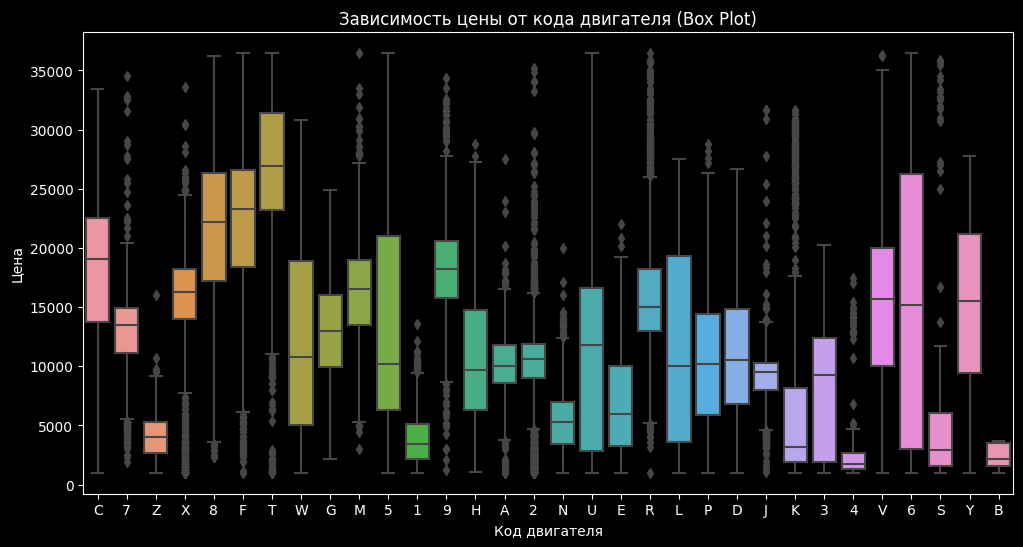

In [155]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='engine', y='Price', data=df)
plt.xlabel('Код двигателя')
plt.ylabel('Цена')
plt.title('Зависимость цены от кода двигателя (Box Plot)')
plt.show()

* **Распределение цен:** Цены на автомобили варьируются в зависимости от кода двигателя. Это может указывать на то, что разные коды соответствуют разным типам двигателей с разной стоимостью.
* **Разброс цен:** Наблюдается значительный разброс цен внутри каждого кода двигателя. Это может быть связано с разными моделями, комплектациями и состоянием автомобилей.
* **Выбросы:** Для некоторых кодов двигателя (например, 'B', 'S', 'V') наблюдаются выбросы, то есть автомобили с очень высокой ценой. Это может быть связано с редкими или особенными типами двигателей.
* **Самые дорогие автомобилии** имеет двигатели `T`, `F`, `8`.


#### Безопасность (Ремни/тормоза)

In [160]:
df['security_codes'].value_counts()

security_codes
D    12370
H    12012
C     9034
F     8376
6     5890
N     3652
5     3078
B     2704
P     2289
E     2038
R     1876
S     1781
Z     1599
Y     1439
J      915
7      634
K      525
G      497
W      434
8      209
L      192
M      189
V       80
X       67
A        3
4        1
Name: count, dtype: int64

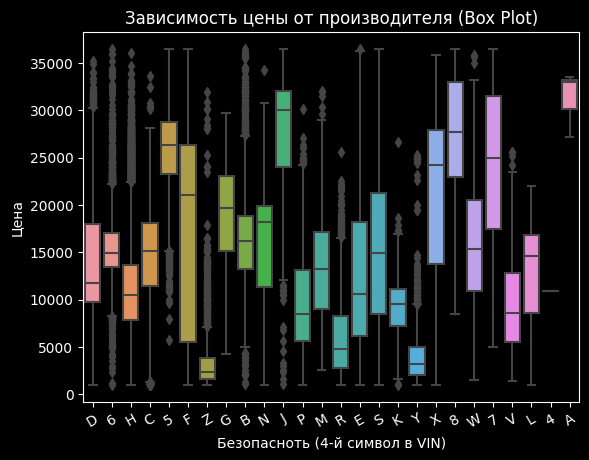

In [186]:
sns.boxplot(x='security_codes', y='Price', data=df)
plt.xlabel('Безопасноть (4-й символ в VIN)')
plt.ylabel('Цена')
plt.title('Зависимость цены от производителя (Box Plot)')
plt.xticks(rotation=30) 
plt.show()

In [164]:
security_codes_groups = (round(df.groupby('security_codes')['Price'].agg(['mean', 'median', 'std', 'count']))
                .sort_values(by='count', ascending=False))
security_codes_groups

,mean,median,std,count
security_codes,,,,
D,13617.0,11800.0,5962.0,12370
H,11470.0,10500.0,5831.0,12012
C,14492.0,15200.0,5136.0,9034
F,17733.0,21100.0,10921.0,8376
6,15371.0,14900.0,3345.0,5890
N,15529.0,18200.0,6335.0,3652
5,25983.0,26300.0,4524.0,3078
B,16768.0,16200.0,5182.0,2704
P,9608.0,8500.0,5299.0,2289


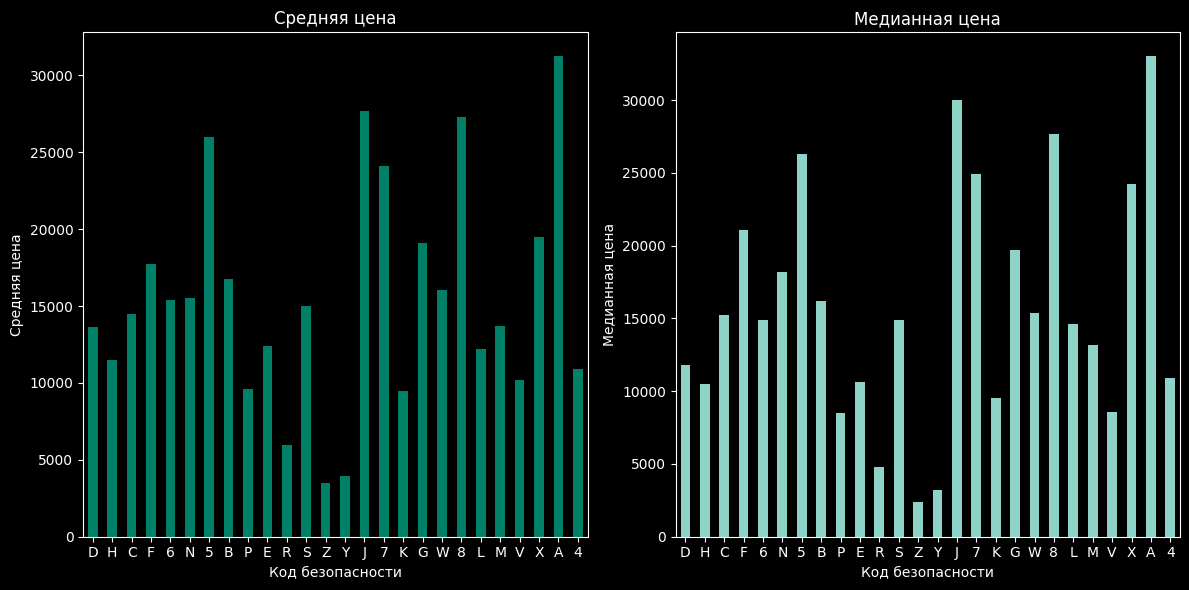

In [168]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
security_codes_groups['mean'].plot(kind='bar',colormap='summer',rot=0)
plt.xlabel('Код безопасности')
plt.ylabel('Средняя цена')
plt.title('Средняя цена')

plt.subplot(1, 2, 2)
security_codes_groups['median'].plot(kind='bar',rot=0)
plt.xlabel('Код безопасности')
plt.ylabel('Медианная цена')
plt.title('Медианная цена')

plt.tight_layout() 
plt.show()

* **Распределение цен:** Цены на автомобили варьируются в зависимости от кода безопасности.
* **Разброс цен:** Наблюдается значительный разброс цен внутри некоторых кодов.
* **Выбросы:** Для некоторых кодов безопасности наблюдаются выбросы, то есть автомобили с очень высокой ценой. Это может быть связано с редкими или особенными типами двигателей.
* **Самые дорогие автомобилии** среди топ-10 по количеству имеют код безопасности `5`, `J`, `8` 


#### Контрольный знак

In [170]:
df[['check_digit']].value_counts()

check_digit
1              6622
5              6581
2              6579
9              6567
0              6565
7              6547
X              6542
4              6503
6              6465
8              6460
3              6453
Name: count, dtype: int64

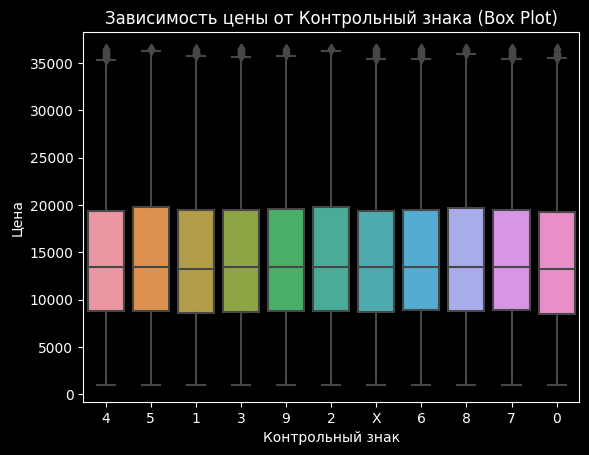

In [185]:
sns.boxplot(x='check_digit', y='Price', data=df)
plt.xlabel('Контрольный знак')
plt.ylabel('Цена')
plt.title('Зависимость цены от Контрольный знака (Box Plot)')
plt.xticks(rotation=0) 
plt.show()

* **Распределение цен и автомобилей:** одинаково для всех контрольных знаков.
* Этот признак не несёт ценности для обучения модели


#### Завод

In [184]:
df[['plant_code']].value_counts()

plant_code
R             10535
K              9112
L              8225
G              7265
U              6732
F              6481
B              5841
5              3692
E              3587
D              3104
M              1884
W              1467
P              1398
N               801
A               453
Z               436
H               362
X               199
C               133
T                97
Y                80
Name: count, dtype: int64

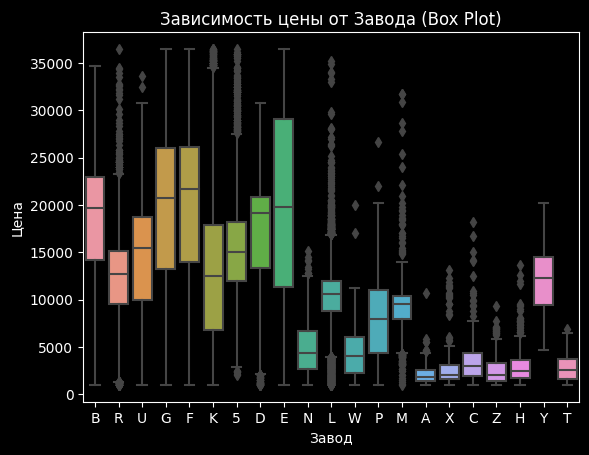

In [187]:
sns.boxplot(x='plant_code', y='Price', data=df)
plt.xlabel('Завод')
plt.ylabel('Цена')
plt.title('Зависимость цены от Завода (Box Plot)')
plt.xticks(rotation=0) 
plt.show()

* **Влияние завода на цену:** Цены на автомобили демонстрируют заметную зависимость от завода-изготовителя.
* **Разброс цен:** Наблюдается значительная вариация цен внутри продукции некоторых заводов (особенно завода E), что может указывать на разнообразие моделей или комплектаций.
* **Объемы производства:** Наибольшее количество автомобилей производится на заводах R, K и L.
* **Ценовой сегмент:**
* **Премиум сегмент:** Самые дорогие автомобили (с точки зрения медианной цены) производятся на заводах F, G и B.
* **Бюджетный сегмент:** Самые доступные автомобили производятся на заводах с наименьшим объемом выпуска, что может свидетельствовать о специализации на нишевых моделях или о меньшей эффективности производства.

### Серийный номер

In [193]:
print('Количество дубликатов серийного номера')
df.duplicated('serial_number',False).sum()

Количество дубликатов серийного номера


7206

In [195]:
df[df.duplicated('serial_number',False)].sort_values('serial_number').head(20)

,VIN,Price,manufacturer,security_codes,model,engine,check_digit,model_year,plant_code,serial_number
23165,2FAHP71W76X100736,2000,2FA,H,P71,W,7,6,X,100736
21965,1FAHP60A42Y100736,13200,1FA,H,P60,A,4,2,Y,100736
17161,3FA6P0D91FR100993,25800,3FA,6,P0D,9,1,F,R,100993
10904,1FAHP2F81FG100993,19500,1FA,H,P2F,8,1,F,G,100993
9280,1FAFP34N76W100993,1000,1FA,F,P34,N,7,6,W,100993
29904,1ZVBP8AM6B5101356,13700,1ZV,B,P8A,M,6,B,5,101356
69273,1FAHP2F80EG101356,15800,1FA,H,P2F,8,0,E,G,101356
61928,1FAHP2F87EG101600,18300,1FA,H,P2F,8,7,E,G,101600
27464,1ZVBP8EMXB5101600,10000,1ZV,B,P8E,M,X,B,5,101600
35908,3FADP4BJXFM101729,11000,3FA,D,P4B,J,X,F,M,101729


* **Дубликаты в серийном номере:** достаточно большое количество (около 10%), но никаких закономерностей с другими признаками не обнаружено.
* **Для обучения модели** признак не несёт пользы на данном этапе.

In [196]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71884 entries, 0 to 71883
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   VIN             71884 non-null  object
 1   Price           71884 non-null  uint32
 2   manufacturer    71884 non-null  object
 3   security_codes  71884 non-null  object
 4   model           71884 non-null  object
 5   engine          71884 non-null  object
 6   check_digit     71884 non-null  object
 7   model_year      71884 non-null  object
 8   plant_code      71884 non-null  object
 9   serial_number   71884 non-null  object
dtypes: object(9), uint32(1)
memory usage: 5.2+ MB


## Обучение и выбор модели

In [213]:
from pycaret.regression import *
from sklearn.model_selection import train_test_split
S = 100500

In [230]:
df = df.set_index('VIN')

In [231]:
X = df[[ 'manufacturer', 'security_codes', 'model', 'engine', 'model_year', 'plant_code']]
y = df[['Price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=S)

In [232]:
train = pd.concat([X_train,y_train],axis=1)

In [233]:
train

,manufacturer,security_codes,model,engine,model_year,plant_code,Price
VIN,,,,,,,
1FMCU0J99DUD30423,1FM,C,U0J,9,D,U,20000
1FTFW1ET7EKE73102,1FT,F,W1E,T,E,K,30500
1FTFW1EV8AFC38633,1FT,F,W1E,V,A,F,20600
3FAHP07127R223637,3FA,H,P07,1,7,R,3800
1FTNE2EW0EDA31393,1FT,N,E2E,W,E,D,20100
...,...,...,...,...,...,...,...
1FMCU0D72CKB39804,1FM,C,U0D,7,C,K,6500
3FAHP0JA0CR201266,3FA,H,P0J,A,C,R,11400
3FADP4BJ7DM191354,3FA,D,P4B,J,D,M,9400


In [246]:
exp = setup(train,train_size=0.8,target='Price',rare_to_value=0.0001,max_encoding_ohe=300,session_id=S)

,Description,Value
0,Session id,100500
1,Target,Price
2,Target type,Regression
3,Original data shape,"(57507, 7)"
4,Transformed data shape,"(57507, 410)"
5,Transformed train set shape,"(46005, 410)"
6,Transformed test set shape,"(11502, 410)"
7,Categorical features,6
8,Preprocess,True
9,Imputation type,simple


In [248]:
%%time
%%chime
best_model = exp.compare_models(sort='MAPE',include=['dummy','lightgbm','xgboost','catboost','et','rf'])

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,00:56:17
Status,. . . . . . . . . . . . . . . . . .,Loading Estimator
Estimator,. . . . . . . . . . . . . . . . . .,Dummy Regressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,1930.6348,7633591.2157,2762.7149,0.8756,0.2669,0.1989,36.7440
et,Extra Trees Regressor,1938.5157,7705253.0698,2775.6482,0.8744,0.2716,0.2005,53.2750
catboost,CatBoost Regressor,1954.4097,7631731.1488,2762.3491,0.8756,0.2784,0.2093,6.7890
lightgbm,Light Gradient Boosting Machine,1993.5316,7976053.7351,2823.8950,0.8700,0.2824,0.2160,1.7300
xgboost,Extreme Gradient Boosting,1985.1838,7818904.8749,2796.0335,0.8725,0.2817,0.2161,3.4750
dummy,Dummy Regressor,6383.7837,61362765.8988,7833.1306,-0.0004,0.7665,1.0279,2.1830


CPU times: total: 2min 37s
Wall time: 18min 12s


In [ ]:
exp.tune_model()

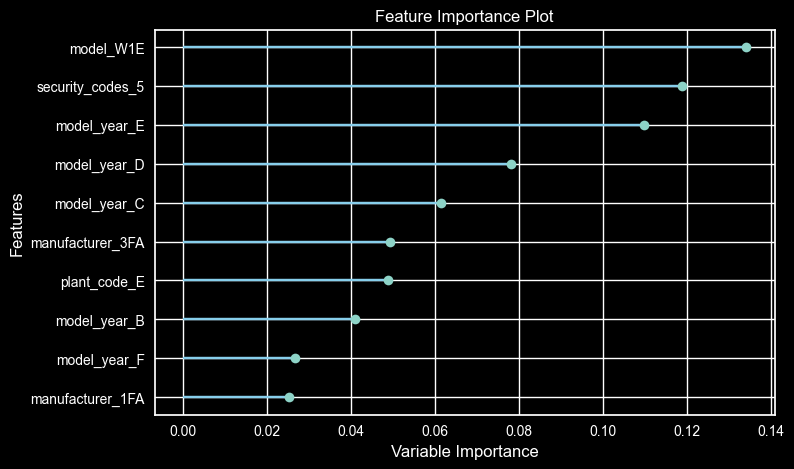

In [252]:
exp.plot_model(best_model,'feature')

In [249]:
%%time
%%chime

exp2 = setup(train,train_size=0.8,target='Price',rare_to_value=0.0001,max_encoding_ohe=3,session_id=S)
best_model_2 = exp2.compare_models(sort='MAPE',include=['dummy','lightgbm','xgboost','catboost','et','rf'])

,Description,Value
0,Session id,100500
1,Target,Price
2,Target type,Regression
3,Original data shape,"(57507, 7)"
4,Transformed data shape,"(57507, 7)"
5,Transformed train set shape,"(46005, 7)"
6,Transformed test set shape,"(11502, 7)"
7,Categorical features,6
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
xgboost,Extreme Gradient Boosting,1927.5380,7545395.0120,2746.7074,0.8770,0.2672,0.2002,0.5150
catboost,CatBoost Regressor,1927.8876,7520587.3632,2742.1771,0.8774,0.2659,0.2005,5.1140
rf,Random Forest Regressor,1935.8815,7672618.2739,2769.8092,0.8749,0.2707,0.2027,2.1720
et,Extra Trees Regressor,1941.0713,7711620.8962,2776.8238,0.8743,0.2739,0.2035,1.6400
lightgbm,Light Gradient Boosting Machine,1957.3824,7721313.1688,2778.4570,0.8741,0.2715,0.2066,0.5220
dummy,Dummy Regressor,6383.7837,61362765.8988,7833.1306,-0.0004,0.7665,1.0279,0.3500


CPU times: total: 18.3 s
Wall time: 1min 58s


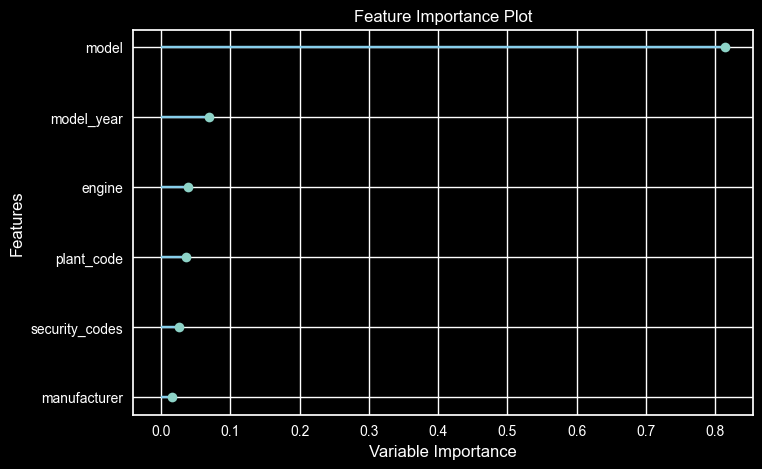

In [251]:
# plt.style.use('dark_background')
exp2.plot_model(best_model_2,'feature')

In [253]:
help(tune_model)

Help on function tune_model in module pycaret.regression.functional:

tune_model(estimator, fold: Union[int, Any, NoneType] = None, round: int = 4, n_iter: int = 10, custom_grid: Union[Dict[str, list], Any, NoneType] = None, optimize: str = 'R2', custom_scorer=None, search_library: str = 'scikit-learn', search_algorithm: Optional[str] = None, early_stopping: Any = False, early_stopping_max_iters: int = 10, choose_better: bool = True, fit_kwargs: Optional[dict] = None, groups: Union[str, Any, NoneType] = None, return_tuner: bool = False, verbose: bool = True, tuner_verbose: Union[int, bool] = True, return_train_score: bool = False, **kwargs)
    This function tunes the hyperparameters of a given estimator. The output of
    this function is a score grid with CV scores by fold of the best selected
    model based on ``optimize`` parameter. Metrics evaluated during CV can be
    accessed using the ``get_metrics`` function. Custom metrics can be added
    or removed using ``add_metric`` an

In [254]:
tuned_model = exp2.tune_model(best_model_2,optimize='MAPE',n_iter=30,search_library='optuna')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1930.3600,7620046.6414,2760.4432,0.8742,0.2718,0.2068
1,1917.7928,7386427.1619,2717.7982,0.8796,0.2546,0.1911
2,1913.5712,7335581.4682,2708.4279,0.8778,0.2518,0.1887
3,1908.2290,7318177.6674,2705.2131,0.8769,0.2653,0.2010
4,1901.7712,7512650.5831,2740.9215,0.8779,0.2713,0.2037
5,1970.9729,7921850.5392,2814.5782,0.8754,0.2704,0.2053
6,1913.5515,7615294.4218,2759.5823,0.8759,0.2610,0.1975
7,1959.1753,7685351.3110,2772.2466,0.8755,0.2659,0.2019
8,1915.8961,7487125.4929,2736.2612,0.8799,0.2704,0.2043


[I 2024-04-18 02:15:57,818] Searching the best hyperparameters using 46005 samples...
[I 2024-04-18 02:21:56,668] Finished hyperparameter search!


In [256]:
tuned_model = exp2.tune_model(tuned_model,optimize='MAPE',n_iter=100, search_library='optuna')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1928.7615,7606906.1834,2758.0620,0.8745,0.2733,0.2071
1,1925.6640,7463390.8270,2731.9207,0.8783,0.2567,0.1919
2,1910.6224,7356222.9402,2712.2358,0.8774,0.2516,0.1882
3,1908.1138,7379406.4469,2716.5063,0.8759,0.2646,0.1996
4,1903.0708,7571947.3648,2751.7172,0.8769,0.2729,0.2032
5,1967.3238,7933155.1509,2816.5857,0.8753,0.2701,0.2039
6,1912.5147,7612635.3332,2759.1005,0.8760,0.2589,0.1959
7,1961.9424,7717989.0611,2778.1269,0.8750,0.2669,0.2026
8,1912.8362,7495284.4853,2737.7517,0.8798,0.2697,0.2027


[I 2024-04-18 02:27:12,159] Searching the best hyperparameters using 46005 samples...
[I 2024-04-18 02:53:19,599] Finished hyperparameter search!


In [259]:
tuned_model

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7033636419144419, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.07235752899247931, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=250, n_jobs=-1,
             num_parallel_tree=None, random_state=100500, ...)

In [258]:
exp2.save_experiment('experement')
exp2.save_model(tuned_model,'tuned_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=[], transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['manufacturer', 'security_codes',
                                              'model', 'engine', 'model_year',
                                              'plant_code'],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('rare_category_grouping',
                  TransformerWrappe...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.07235752899247931, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None,